In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

def load_statistics(pointcloud_type, base_path, scene_name):
    """
    Loads statistics from a CSV file.

    Args:
        pointcloud_type: The type of point cloud (e.g., 'lidar', 'mast3r').
        base_path: The base directory where the CSV files are stored.
        scene_name: The name of the scene.

    Returns:
        A pandas DataFrame containing the loaded statistics, or None if the file is not found.
    """
    csv_file = os.path.join(base_path, f"{scene_name}_{pointcloud_type}.csv")  # Construct the CSV file path
    try:
        df = pd.read_csv(csv_file)
        return df
    except FileNotFoundError:
        print(f"Warning: CSV file not found for {pointcloud_type} at {csv_file}")
        return None
    

BASE_PATH = "results_localization/spagna_train0"
TYPES = ['mast3r', 'lidar', 'mast3r_scaled_v3', 'mast3r_scaled_v4', 'mast3r_scaled_icp']
scene_name = "spagna"
loaded_data = {}
for pointcloud_type in TYPES:
    df = load_statistics(pointcloud_type, BASE_PATH, scene_name=scene_name)
    if df is not None:
        # Convert numeric columns
        numeric_columns = ["n_matches", "n_inliers", "n_overlapping", "median_depth",
                           "x_error", "y_error", "z_error", "pos_error", "rot_error",
                           "distance_anchor_query", "pointmap_error_x", "pointmap_error_y", "pointmap_error_z"]
 
        scale_cols = [col for col in df.columns if col.startswith("scale")]
        numeric_columns.extend(scale_cols)

        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

        loaded_data[pointcloud_type] = df


/tmp/ipykernel_1842855/3118607783.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)


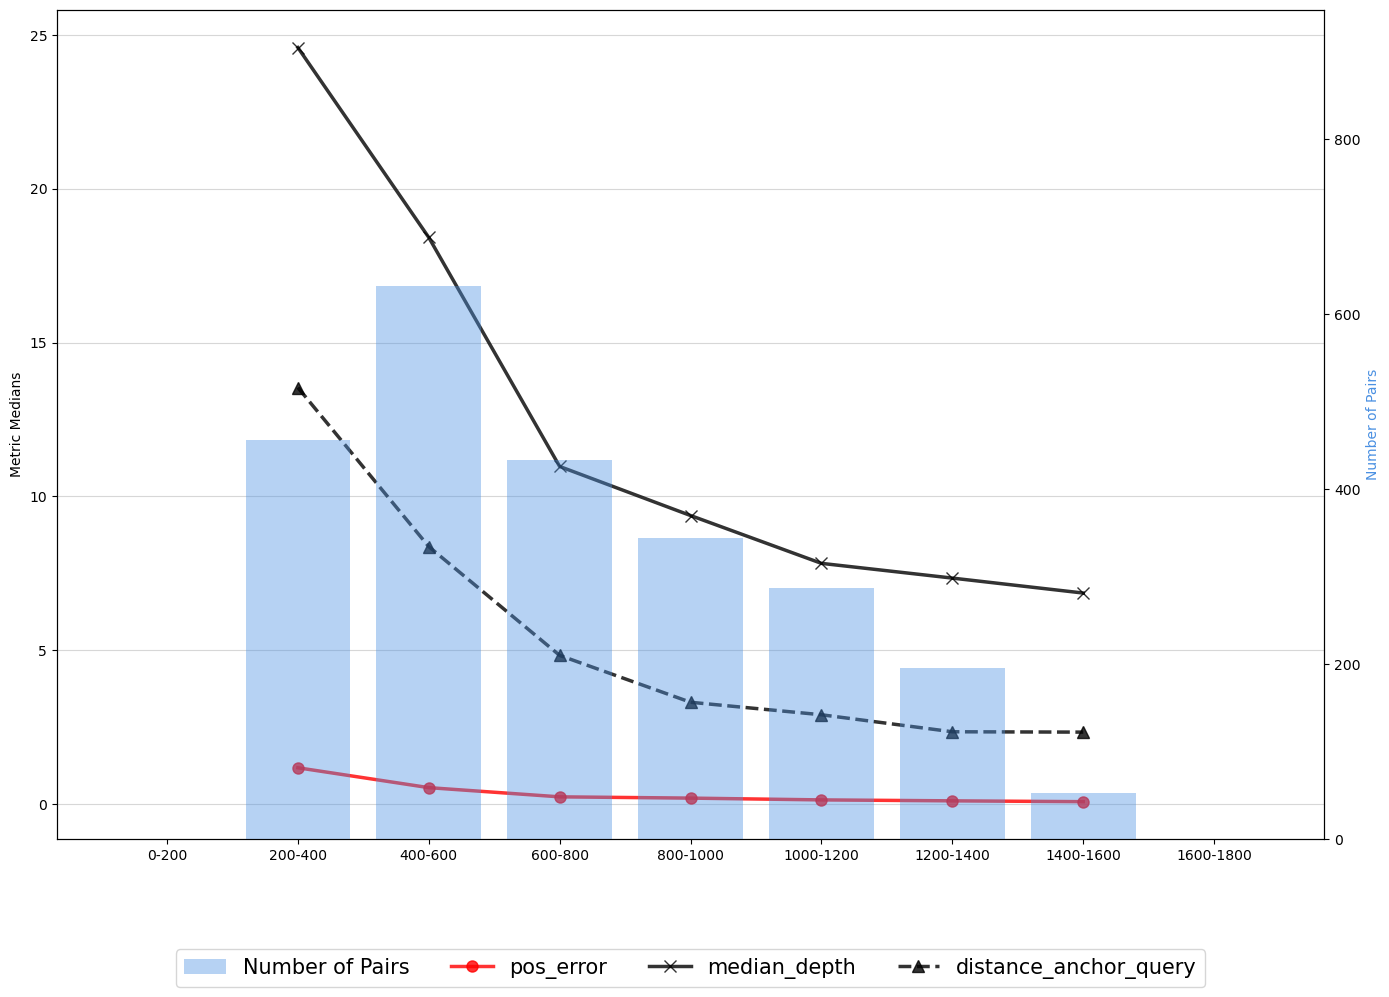

In [2]:
def plot_metrics_per_bin(dataset_to_plot, bin_by, metrics_to_plot, annotation_metrics, bin_min=None, bin_max=None):
    """
    Plot metrics per bin for a specific dataset, including bar plots for pair counts
    and line plots for metric medians, with optional custom bin limits.
    
    Args:
        dataset_to_plot: Name of the dataset to plot.
        bin_by: Column name to bin by (e.g., 'num_inliers' or 'num_matches').
        metrics_to_plot: Dictionary of metrics to plot with their configurations.
        annotation_metrics: List of metrics to annotate on the bar plot.
        bin_min: Minimum bin limit (default: None, uses data minimum).
        bin_max: Maximum bin limit (default: None, uses data maximum).
    """
    df = loaded_data[dataset_to_plot]
    df_ok = df[df['status'] == 'OK']

    # Determine bin limits
    data_min = df_ok[bin_by].min()
    data_max = df_ok[bin_by].max()
    bin_min = bin_min if bin_min is not None else 0
    bin_max = bin_max if bin_max is not None else int(data_max) + BIN_WIDTH

    # Create bins based on the selected binning column and custom limits
    bins = range(bin_min, bin_max, BIN_WIDTH)
    bin_column = f"{bin_by}_bin"
    df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)

    # Group by the bins and compute statistics
    grouped = df_ok.groupby(bin_column)
    count_by_bin = grouped.size()

    # Compute median for annotation metrics
    annotation_medians = {metric: grouped[metric].median() for metric in annotation_metrics if metric in df_ok.columns}

    # Compute median for each selected metric to plot
    metric_medians = {metric: grouped[metric].median() for metric in metrics_to_plot.keys() if metric in df_ok.columns}

    # Convert bin intervals to numeric values (midpoints)
    bin_midpoints = [interval.mid for interval in count_by_bin.index]

    # Create the plot
    fig, ax2 = plt.subplots(figsize=(14, 10))
    ax1 = ax2.twinx()
    # Bar plot: number of pairs per bin (left y-axis)
    bars = ax1.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=BIN_WIDTH * 0.8, alpha=0.4, label="Number of Pairs")
    ax1.set_ylabel("Number of Pairs", color="#4A90E2")
    ax1.set_xlabel(f"{bin_by} (binned)")
    ax1.set_xticks(bin_midpoints)
    ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in count_by_bin.index], rotation=45, ha="right")
    ax1.set_ylim(0, max(count_by_bin) * 1.5)

    # # Annotate bars with median values of selected metrics
    # for i, bar in enumerate(bars):
    #     annotation_text = [f"{metric}:{annotation_medians[metric].iloc[i]:.0f}" for metric in annotation_metrics if metric in annotation_medians]
    #     if annotation_text:
    #         ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + max(count_by_bin) * 0.02, " \n ".join(annotation_text), ha="center", va="bottom", fontsize=9, color="#2C3E50", weight="bold")

    # Add line plots for metric medians (right y-axis)
    
    ax2.set_ylabel("Metric Medians", color="black")
    line_plots = []
    for metric, config in metrics_to_plot.items():
        if metric in metric_medians:
            line = ax2.plot(bin_midpoints, metric_medians[metric], 
                            color=config['color'], marker=config['marker'], 
                            label=config['label'], linewidth=2.5, linestyle=config['linestyle'],markersize=8, alpha=0.8)
            line_plots.append((line[0], config['label']))

    # Combine legends
    legend_items = [(bars, "Number of Pairs")] + line_plots
    handles, labels = zip(*legend_items)
    ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=min(len(handles), 4), fontsize=15)

    # Add grid lines
    ax2.grid(axis="y", linestyle="-", alpha=0.5)
    # ax2.grid(axis="y", linestyle=".", alpha=0.3)
    # Dynamic title based on binning variable
    bin_label = "Matches" if bin_by == 'num_matches' else "Inliers"
    # plt.title(f"Metrics per {bin_label} Bin ({dataset_to_plot})", fontsize=14)
    plt.tight_layout()
    plt.show()
BIN_WIDTH=200
# Example usage with custom bin limits
plot_metrics_per_bin(
    dataset_to_plot='lidar',
    bin_by='n_inliers',
    metrics_to_plot={
        'pos_error': {'color': 'red', 'marker': 'o', 'linestyle': '-', 'label': "pos_error"},
        'median_depth': {'color': 'black', 'marker': 'x', 'linestyle': '-', 'label': 'median_depth'},
        'distance_anchor_query': {'color': 'black', 'marker': '^', 'linestyle': '--', 'label': 'distance_anchor_query'},
    },
    annotation_metrics=['n_inliers', 'n_overlapping'],
    bin_min=None,  # Custom minimum bin limit
    bin_max=2000   # Custom maximum bin limit
)



In [3]:


# Table 1: Success rate and num_inliers (median)
table1_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    table1_data.append({
        'method': pointcloud_type,
        'n_success': len(ok_pairs),
        'n_total': len(df),
        'success_rate': len(ok_pairs) / len(df) if len(df) > 0 else 0,
        'num_inliers_median': ok_pairs['n_inliers'].median() if len(ok_pairs) > 0 else np.nan
    })

table1 = pd.DataFrame(table1_data)
print("Table 1: Success Rates and Inliers")
print(table1)
print()

# Table 2: Position and rotation errors (median)
table2_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    table2_data.append({
        'method': pointcloud_type,
        'pos_error_median': ok_pairs['pos_error'].median() if len(ok_pairs) > 0 else np.nan,
        'x_error_median': ok_pairs['x_error'].median() if len(ok_pairs) > 0 else np.nan,
        'y_error_median': ok_pairs['y_error'].median() if len(ok_pairs) > 0 else np.nan,
        'z_error_median': ok_pairs['z_error'].median() if len(ok_pairs) > 0 else np.nan,
        'rot_error_median': ok_pairs['rot_error'].median() if len(ok_pairs) > 0 else np.nan
    })

table2 = pd.DataFrame(table2_data)
print("Table 2: Position and Rotation Errors (Median)")
print(table2.to_string(index=False))
print()

# Table 3: Distance and scales (mean and median)
table3_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    
    row = {
        'method': pointcloud_type,
        'distance_mean': ok_pairs['median_depth'].mean() if 'median_depth' in ok_pairs.columns and len(ok_pairs) > 0 else np.nan,
        'distance_median': ok_pairs['median_depth'].median() if 'median_depth' in ok_pairs.columns and len(ok_pairs) > 0 else np.nan,
    }
    
    # Add scale statistics
    if 'scale' in ok_pairs.columns:
        # row['scale_mean'] = ok_pairs['scale'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_median'] = ok_pairs['scale'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_x' in ok_pairs.columns:
        # row['scale_x_mean'] = ok_pairs['scale_x'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_x_median'] = ok_pairs['scale_x'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_y' in ok_pairs.columns:
        # row['scale_y_mean'] = ok_pairs['scale_y'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_y_median'] = ok_pairs['scale_y'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_z' in ok_pairs.columns:
        # row['scale_z_mean'] = ok_pairs['scale_z'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_z_median'] = ok_pairs['scale_z'].median() if len(ok_pairs) > 0 else np.nan
    
    table3_data.append(row)

table3 = pd.DataFrame(table3_data)
print("Table 3: Distance and Scale Statistics")
print(table3.to_string(index=False))

Table 1: Success Rates and Inliers
              method  n_success  n_total  success_rate  num_inliers_median
0             mast3r       2403     2485      0.967002               643.0
1              lidar       2401     2485      0.966197               643.0
2   mast3r_scaled_v3       2403     2485      0.967002               643.0
3   mast3r_scaled_v4       2404     2485      0.967404               643.0
4  mast3r_scaled_icp       2403     2485      0.967002               643.0

Table 2: Position and Rotation Errors (Median)
           method  pos_error_median  x_error_median  y_error_median  z_error_median  rot_error_median
           mast3r          4.742185        1.547878        0.226296        2.748917          0.041825
            lidar          0.274742        0.114506        0.067129        0.187131          0.018155
 mast3r_scaled_v3          1.422239        0.368277        0.119126        1.106680          0.041764
 mast3r_scaled_v4          1.061876        0.338139        

In [4]:
import logging
print(logging.__version__)

0.5.1.2


Using lidar as reference for binning
Binning by: n_inliers
Comparing metric: pos_error
Total pairs in reference: 2485, Successful pairs: 2401


/tmp/ipykernel_1842855/474042404.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref_ok[bin_column] = pd.cut(df_ref_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_1842855/474042404.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_1842855/474042404.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

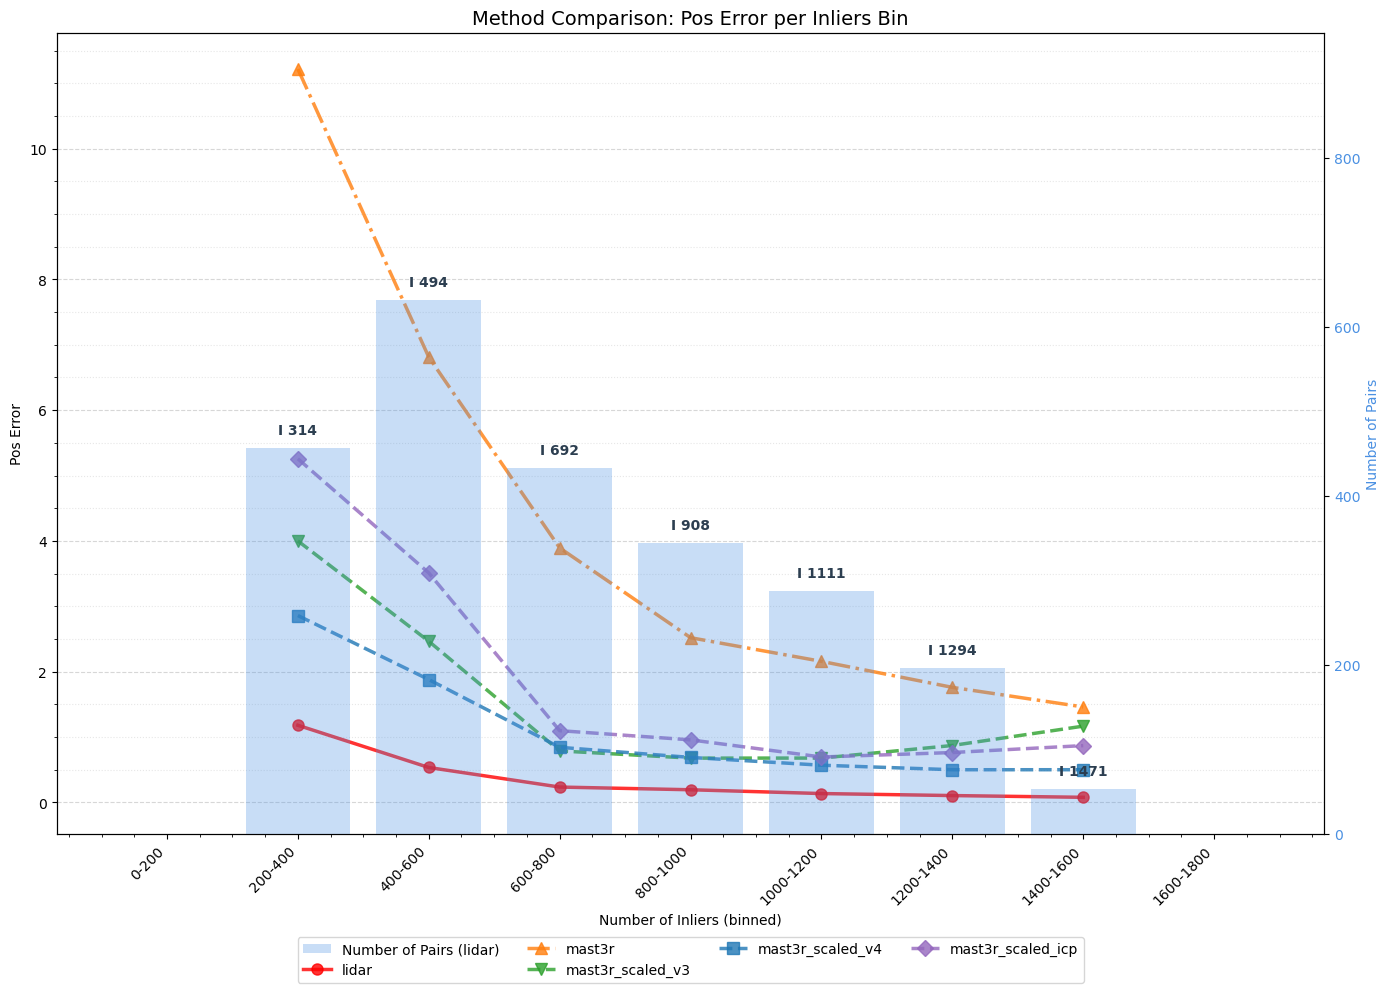


Comparison Statistics for pos_error:
lidar:
  Mean: 0.351
  Median: 0.193
  Min: 0.078
  Max: 1.180
mast3r:
  Mean: 4.260
  Median: 2.519
  Min: 1.460
  Max: 11.219
mast3r_scaled_v3:
  Mean: 1.521
  Median: 0.870
  Min: 0.677
  Max: 4.000
mast3r_scaled_v4:
  Mean: 1.119
  Median: 0.688
  Min: 0.500
  Max: 2.858
mast3r_scaled_icp:
  Mean: 1.878
  Median: 0.956
  Min: 0.694
  Max: 5.256


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Dynamic configuration
reference_dataset = 'lidar'  # Dataset to use for histogram/binning
bin_width = 200  # Adjust bin width as needed
bin_by = 'n_inliers'  # Change this to 'num_matches' or 'num_inliers'

# Custom bin limits (set to None for default behavior)
bin_min = 0  # Minimum bin limit (set to None for default)
bin_max = 2000  # Maximum bin limit (set to None for default)

# Choose which metric to compare across methods
metric_to_compare = 'pos_error'  # Change this to any metric you want to compare

# Choose which methods to compare (can select multiple) 
methods_to_compare = {
    'lidar': {'color': 'red', 'marker': 'o', 'linestyle': '-'},            # Red
    'mast3r': {'color': '#ff7f0e', 'marker': '^', 'linestyle': '-.'},          # Orange
    'mast3r_scaled_v3': {'color': '#2ca02c', 'marker': 'v', 'linestyle': '--'},# Green
    'mast3r_scaled_v4': {'color': '#1f77b4', 'marker': 's', 'linestyle': '--'}, # Blue
    'mast3r_scaled_icp': {'color': '#9467bd', 'marker': 'D', 'linestyle': '--'} # Purple
}

# Get the reference dataset for binning
df_ref = loaded_data[reference_dataset]
df_ref_ok = df_ref[df_ref['status'] == 'OK']

print(f"Using {reference_dataset} as reference for binning")
print(f"Binning by: {bin_by}")
print(f"Comparing metric: {metric_to_compare}")
print(f"Total pairs in reference: {len(df_ref)}, Successful pairs: {len(df_ref_ok)}")

# Validate binning column exists
if bin_by not in df_ref_ok.columns:
    raise ValueError(f"Error: Column '{bin_by}' not found in reference dataset!")

# Determine bin limits
data_min = df_ref_ok[bin_by].min()
data_max = df_ref_ok[bin_by].max()
bin_min = bin_min if bin_min is not None else 0
bin_max = bin_max if bin_max is not None else int(data_max) + bin_width

# Create bins based on reference dataset and selected binning column
bins = range(bin_min, bin_max, bin_width)
bin_column = f"{bin_by}_bin"
df_ref_ok[bin_column] = pd.cut(df_ref_ok[bin_by], bins=bins, right=False)

# Group reference data for histogram
grouped_ref = df_ref_ok.groupby(bin_column)
count_by_bin = grouped_ref.size()
median_inliers_by_bin = grouped_ref["n_inliers"].median()

# Convert bin intervals to numeric values (midpoints)
bin_midpoints = [interval.mid for interval in count_by_bin.index]

# Prepare data for all methods
method_data = {}
for method_name, config in methods_to_compare.items():
    if method_name in loaded_data:
        df = loaded_data[method_name]
        df_ok = df[df['status'] == 'OK']
        
        # Apply the same binning to this method's data
        df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
        grouped = df_ok.groupby(bin_column)
        
        # Compute the metric for this method
        if metric_to_compare in df_ok.columns:
            metric_values = grouped[metric_to_compare].median()
            # Reindex to match the reference bins (fill missing bins with NaN)
            metric_values = metric_values.reindex(count_by_bin.index)
            method_data[method_name] = metric_values
        else:
            print(f"Warning: {metric_to_compare} not found in {method_name}")

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 10))


ax1.set_ylabel(f"{metric_to_compare.replace('_', ' ').title()}", color="black")

# Plot the metric for each method
line_plots = []
for method_name, config in methods_to_compare.items():
    if method_name in method_data:
        line = ax1.plot(bin_midpoints, method_data[method_name], 
                       color=config['color'], marker=config['marker'], 
                       linestyle=config['linestyle'], label=method_name,
                       linewidth=2.5, markersize=8, alpha=0.8)
        line_plots.append((line[0], method_name))

# Create secondary y-axis for the metric comparison
ax2 = ax1.twinx()

# Bar plot: number of pairs per bin from reference dataset (left y-axis)
bars = ax2.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=bin_width * 0.8, alpha=0.3, 
               label=f"Number of Pairs ({reference_dataset})")
ax2.set_ylabel("Number of Pairs", color="#4A90E2")
ax2.tick_params(axis="y", labelcolor="#4A90E2")

# Dynamic x-axis label based on binning variable
x_label = "Number of Matches (binned)" if bin_by == 'n_matches' else "Number of Inliers (binned)"
ax1.set_xlabel(x_label)
ax1.set_xticks(bin_midpoints)
ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in count_by_bin.index], 
                    rotation=45, ha="right")
ax2.set_ylim(0, max(count_by_bin) * 1.5)

# Annotate bars with median inliers from reference dataset
for i, (bar, median_inliers) in enumerate(zip(bars, median_inliers_by_bin)):
    if not pd.isna(median_inliers):
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(count_by_bin) * 0.02,
            f"I {median_inliers:.0f}",
            ha="center", va="bottom", fontsize=10, color="#2C3E50", weight="bold"
        )

# # Plot distance_anchor_query from lidar dataset on the same axis as pos_error
# if 'lidar' in method_data and 'distance_anchor_query' in loaded_data['lidar'].columns:
#     # Get the median distance_anchor_query per bin
#     distance_anchor_query_median = df_ref_ok.groupby(bin_column)['distance_anchor_query'].median()
#     distance_anchor_query_median = distance_anchor_query_median.reindex(count_by_bin.index)  # Ensure correct bin alignment
    
#     # Plot distance_anchor_query on ax2
#     line_distance = ax1.plot(bin_midpoints, distance_anchor_query_median, 
#                              color="green", marker="D", linestyle="--", label="Dist. Anchor Query (Lidar)",
#                              linewidth=2, markersize=6, alpha=0.7)
#     line_plots.append((line_distance[0], "Dist. Anchor Query (Lidar)"))

# Combine legends
legend_items = [(bars, f"Number of Pairs ({reference_dataset})")] + line_plots
handles, labels = zip(*legend_items)
ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), 
          ncol=min(len(handles), 4), fontsize=10)

# Add minor grid lines
ax1.minorticks_on()
ax1.grid(which="minor", axis="y", linestyle=":", alpha=0.3)
ax1.grid(which="major", axis="y", linestyle="--", alpha=0.5)

# Dynamic title based on binning variable
bin_label = "Matches" if bin_by == 'num_matches' else "Inliers"
plt.title(f"Method Comparison: {metric_to_compare.replace('_', ' ').title()} per {bin_label} Bin", fontsize=14)
plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\nComparison Statistics for {metric_to_compare}:")
print("=" * 50)
for method_name in methods_to_compare.keys():
    if method_name in method_data:
        values = method_data[method_name].dropna()
        if len(values) > 0:
            print(f"{method_name}:")
            print(f"  Mean: {values.mean():.3f}")
            print(f"  Median: {values.median():.3f}")
            print(f"  Min: {values.min():.3f}")
            print(f"  Max: {values.max():.3f}")
        else:
            print(f"{method_name}: No data available")
    else:
        print(f"{method_name}: Not loaded")

In [6]:

import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'mast3r' data is loaded
if 'mast3r' not in loaded_data:
    print("Error: 'mast3r' data not found. Please ensure the data is loaded correctly.")
else:
    df_mast3r = loaded_data['mast3r']
    df_mast3r_ok = df_mast3r[df_mast3r['status'] == 'OK']

    # Check if required columns are available
    required_columns = ['median_depth', 'pointmap_error_x', 'pointmap_error_y', 'pointmap_error_z']
    missing_columns = [col for col in required_columns if col not in df_mast3r_ok.columns]

    if missing_columns:
        print(f"Error: Missing required columns in mast3r data: {missing_columns}")
    else:
        # Configuration
        bin_width = 5  # Adjust bin width as needed for depth
        bin_by = 'median_depth'
        bin_min = min(0,df_mast3r_ok[bin_by].min())
        bin_max = df_mast3r_ok[bin_by].max()

        # Create bins
        bins = range(int(bin_min), int(bin_max) + bin_width, bin_width)
        bin_column = f"{bin_by}_bin"
        df_mast3r_ok[bin_column] = pd.cut(df_mast3r_ok[bin_by], bins=bins, right=False)

        # Group by bin
        grouped = df_mast3r_ok.groupby(bin_column)
        bin_midpoints = [interval.mid for interval in grouped.size().index]

        # Calculate median pointmap errors per bin
        pointmap_error_x_median = grouped['pointmap_error_x'].median()
        pointmap_error_y_median = grouped['pointmap_error_y'].median()
        pointmap_error_z_median = grouped['pointmap_error_z'].median()

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(14, 10))

        # Plot 1: Pointmap Errors vs. Binned Metric
        ax1.plot(bin_midpoints, pointmap_error_x_median.values, color='red', label='Pointmap Error X', marker='o')
        ax1.plot(bin_midpoints, pointmap_error_y_median.values, color='green', label='Pointmap Error Y', marker='s')
        ax1.plot(bin_midpoints, pointmap_error_z_median.values, color='blue', label='Pointmap Error Z', marker='^')
        ax1.set_xlabel(f'{bin_by} (binned)')
        ax1.set_ylabel('Median Pointmap Error (meters)')
        ax1.set_title('Median Pointmap Errors vs. Binned Median Depth (mast3r)')
        ax1.legend()
        ax1.grid(True,linestyle='-.')
        # Create secondary y-axis for the metric comparison
        ax2 = ax1.twinx()
        # Plot 2: Histogram of Median Predicted Depth
        n, bins, patches = ax2.hist(df_mast3r_ok['median_depth'], bins=bins, color='skyblue', edgecolor='black', alpha=0.4)
        ax2.set_xlabel('Median Predicted Depth (meters)')
        ax2.set_ylabel('Frequency')
        # ax2.set_title('Distribution of Median Predicted Depth (mast3r)')
        ax2.grid(True)

        # Customize x-axis ticks and labels to show bin ranges
        bin_labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins)-1)]
        ax2.set_xticks([(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)])
        ax2.set_xticklabels(bin_labels, rotation=45, ha='right')
        fig.tight_layout()
        plt.show()


Error: Missing required columns in mast3r data: ['pointmap_error_x', 'pointmap_error_y', 'pointmap_error_z']
